## Check available ATL03 files over Ross Sea

#### Check available ATL03 files in ICESat-2 server (Ross Sea)

In [1]:
## Check available ATL03 data over Ross Sea and convert to csv files

import os, sys
import h5py
from glob import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import scipy.signal
import datetime as dt
import pandas as pd
import netCDF4
import time

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)

# make sure we're dealing with the most recent version of any code we're using
%load_ext autoreload
%autoreload 2

from readers.get_ATL10 import get_ATL10data
from readers.getATL07 import getATL07

data_dir='F:\\ATL03\\ATL07\\RossSea\\h5'
lst = os.listdir(data_dir)
lst = sorted(lst)

first = True
print("READY TO GO")


READY TO GO


In [2]:
lst

['ATL07-02_20190201190211_05400201_004_01.h5',
 'ATL07-02_20190216185428_07690201_004_01.h5',
 'ATL07-02_20190301180351_09670201_004_01.h5',
 'ATL07-02_20190309192128_10900201_004_01.h5',
 'ATL07-02_20190313173850_11500201_004_01.h5',
 'ATL07-02_20191005204240_01370501_004_01.h5',
 'ATL07-02_20191006201700_01520501_004_01.h5',
 'ATL07-02_20191008192541_01820501_004_01.h5',
 'ATL07-02_20191009190002_01970501_004_01.h5',
 'ATL07-02_20191014182603_02730501_004_01.h5',
 'ATL07-02_20191017184322_03190501_004_01.h5',
 'ATL07-02_20191018181743_03340501_004_01.h5',
 'ATL07-02_20191019175205_03490501_004_01.h5',
 'ATL07-02_20191021200922_03810501_004_01.h5',
 'ATL07-02_20191024185224_04260501_004_01.h5',
 'ATL07-02_20191025200102_04420501_004_01.h5',
 'ATL07-02_20191026193522_04570501_004_01.h5',
 'ATL07-02_20191027190943_04720501_004_01.h5',
 'ATL07-02_20191028184403_04870501_004_01.h5',
 'ATL07-02_20191031190122_05330501_004_01.h5',
 'ATL07-02_20191103174424_05780501_004_01.h5',
 'ATL07-02_20

In [4]:
year = 2019
csvlist = sorted(glob("F:\\ATL03\\ATL07\\RossSea\\ATL07_S2_{0}*.csv".format(year)))
df = pd.read_csv(csvlist[0])
files = df['IS2_file'].unique()

for file in files[:]:
    filename = data_dir + "\\ATL07_" + file    
    print(filename)
    

F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191005204240_01370501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191006201700_01520501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191008192541_01820501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191009190002_01970501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191014182603_02730501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191017184322_03190501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191018181743_03340501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191019175205_03490501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191021200922_03810501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191024185224_04260501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191025200102_04420501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191026193522_04570501_004_01.h5
F:\ATL03\ATL07\RossSea\h5\ATL07_ATL07-02_20191027190943_04720501_004_01.h5
F:\ATL03\ATL07\RossSea\h5

In [11]:
import geopandas
from shapely.geometry import Point
import time

# Function to convert pandas dataframe to ESRI shapefile
def convertshp(df, outfile):
    '''
    === input
        - df: input pandas dataframe
        - outfile: the nampe of the output shapefile
    '''   

    df=df.reset_index(drop=True)

    if len(df) > 0:
        df['geometry'] = df.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1)
        collist = list(df.columns)
        if 'time' in collist:
            collist.remove('time')
        df2 = df[collist]

        df2 = geopandas.GeoDataFrame(df2, geometry='geometry')

        # proj WGS84
        df2.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

        df2.to_file(outfile, driver='ESRI Shapefile')

    print('... converted to ' + outfile)


In [24]:
# Read ATL03 file and convert for every valid files ============================

for year in [2018, 2019, 2020]:
    csvlist = sorted(glob("F:\\ATL03\\ATL07\\RossSea\\ATL07_S2_{0}*.csv".format(year)))
    df = pd.read_csv(csvlist[0])
    files = df['IS2_file'].unique()

    bbox = [170, -78, -140, -70] # Ross Sea
    # bounding_box = [ll_lon, ll_lat, ur_lon, ur_lat]

    for file in files[:]:
        
        filename = data_dir + "\\" + file
        
        if os.path.exists(filename):
            print(filename)
            first = True
            
            for beam_number in [0, 2, 4]:
                t1 = time.time()
                df07 = getATL07(filename, beam_number, bbox)
                t2 = time.time()                              

                if len(df07) > 100:
                    beam = df07['beam'][0]
                    
                    if first:
                        df = df07
                        first = False
                    else:
                        df = df.append(df07).reset_index(drop=True)
                        
            print("... ATL07 file was read (%.3f s)"%(t2-t1))
            
            # convert ATL03 dataframe to shpfile
            shppath = "F:\\ATL03\\ATL07\\RossSea\\shpfile\\"
            shpfile = shppath + file.replace('processed_', '').replace('_004_01.h5', '.shp')
            convertshp(df, shpfile)

            # save ATL03 dataframe as csvfile
            csvpath = "F:\\ATL03\\ATL07\\RossSea\\csv\\"
            csvfile = csvpath + file.replace('processed_', '').replace('_004_01.h5', '.csv')
            df.to_csv(csvfile)
                        
        else:
            print("No file: {0}".format(file))

        print("==================================================================")
    print("======================= FINISH ===================================")

F:\ATL03\ATL07\RossSea\h5\ATL07-02_20190201190211_05400201_004_01.h5
... ATL07 file was read (0.150 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20190201190211_05400201.shp
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20190216185428_07690201_004_01.h5
... ATL07 file was read (0.239 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20190216185428_07690201.shp
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20190301180351_09670201_004_01.h5
... ATL07 file was read (0.161 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20190301180351_09670201.shp
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20190309192128_10900201_004_01.h5
... ATL07 file was read (0.107 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20190309192128_10900201.shp
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20190313173850_11500201_004_01.h5
... ATL07 file was read (0.237 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20190313173850_11500201.shp
======================= FINISH =============================

... ATL07 file was read (0.747 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20191206174623_10820501.shp
======================= FINISH ===================================
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20210209185529_07301001_004_01.h5
... ATL07 file was read (0.082 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20210209185529_07301001.shp
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20210215193007_08221001_004_01.h5
... ATL07 file was read (0.130 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20210215193007_08221001.shp
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20210216203845_08381001_004_01.h5
... ATL07 file was read (0.287 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20210216203845_08381001.shp
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20210218194727_08681001_004_01.h5
... ATL07 file was read (0.110 s)
... converted to F:\ATL03\ATL07\RossSea\shpfile\ATL07-02_20210218194727_08681001.shp
F:\ATL03\ATL07\RossSea\h5\ATL07-02_20210219192149_08831001_004

In [22]:
df

,beam,lat,lon,x,deltatime,height,h_mean,h_median,h_diff,width,...,sic,stype,seg_len,time,year,month,day,hour,minute,second
0,gt1l,-74.912118,-142.346222,3.178181e+07,3.428741e+07,0.756001,0.780208,0.728021,0.052187,0.433,...,100.000000,1,11.359826,2019-02-01 20:17:07.045916,2019,2,1,20,17,7
1,gt1l,-74.912118,-142.346222,3.178181e+07,3.428741e+07,0.754282,0.780208,0.728021,0.052187,0.433,...,100.000000,1,11.359826,2019-02-01 20:17:07.045916,2019,2,1,20,17,7
2,gt1l,-74.912118,-142.346222,3.178181e+07,3.428741e+07,0.750790,0.780208,0.728021,0.052187,0.433,...,100.000000,1,11.359826,2019-02-01 20:17:07.045916,2019,2,1,20,17,7
3,gt1l,-74.912118,-142.346222,3.178181e+07,3.428741e+07,0.742948,0.780208,0.728021,0.052187,0.433,...,100.000000,1,11.359826,2019-02-01 20:17:07.045916,2019,2,1,20,17,7
4,gt1l,-74.912075,-142.346246,3.178181e+07,3.428741e+07,1.132964,1.182259,1.193998,-0.011739,0.922,...,100.000000,1,12.080376,2019-02-01 20:17:07.046597,2019,2,1,20,17,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26169,gt1l,-73.540749,-143.077753,3.193647e+07,3.428743e+07,-0.014055,-0.034628,-0.018766,-0.015863,0.138,...,15.217178,8,52.485138,2019-02-01 20:17:28.950058,2019,2,1,20,17,28
26170,gt1l,-73.540531,-143.077865,3.193650e+07,3.428743e+07,-0.016704,-0.038302,-0.023945,-0.014356,0.116,...,15.173039,6,48.213905,2019-02-01 20:17:28.953516,2019,2,1,20,17,28
26171,gt1l,-73.540334,-143.077966,3.193652e+07,3.428743e+07,0.010272,-0.006134,0.001110,-0.007244,0.118,...,15.131452,6,45.298958,2019-02-01 20:17:28.956657,2019,2,1,20,17,28
26172,gt1l,-73.540132,-143.078070,3.193654e+07,3.428743e+07,-0.026252,-0.017687,-0.015570,-0.002117,0.129,...,15.093468,6,45.916336,2019-02-01 20:17:28.959872,2019,2,1,20,17,28


In [ ]:
# Read ATL03 file and convert for every valid files ============================

for year in [2019]:
    csvlist = sorted(glob("F:\\ATL03\\ATL03\\RossSea\\ATL03_S2_{0}*.csv".format(year)))
    df = pd.read_csv(csvlist[0])
    files = df['ATL03_file'].unique()

    bbox = [170, -78, -140, -70] # Ross Sea
    # bounding_box = [ll_lon, ll_lat, ur_lon, ur_lat]

    for file in files[:]:
        
        filename = data_dir + "\\" + file

        if os.path.exists(filename):
            print(filename)

            for beam_number in [0, 2, 4]:
                t1 = time.time()
                df03 = getATL03(filename, beam_number, bbox)
                t2 = time.time()
                print("... ATL03 file was read (%.3f s)"%(t2-t1))

                if len(df03) > 100:
                    beam = df03['beam'][0]

                    stats = ['mean', 'sd', 'med'] # calculated statistical parameters
                    variables = ['height', 'pcnt', 'pcnth', 'bcnt', 'brate'] # calculated variables
                    df_sam1 = sampling_ATL03(df03, stats, variables)
                    t2 = time.time()
                    print("... ATL03 file was resampled (%.3f s)"%(t2-t1))

                    if len(df_sam1) > 100:
                        # the sampling process is done based on high-confidence photons (conf >= 3)

                        # First photon bias correction
                        correction = fpb_correction(filename, beam, df_sam1['pcnt_mean'])
                        df_sam1['fpb_corr'] = correction
                        t2 = time.time()
                        print("... First photon bias correction (%.3f s)"%(t2-t1))

                        # Add MSS
                        if df_sam1['lat'][0] < 0:
                            ncfile = r"F:\\ATL03\\ATL03\\MSS\\mss_antarc.nc"
                        else:
                            ncfile = r"F:\\ATL03\\ATL03\\MSS\\mss_arctic.nc"
                        # MSS boundary
                        maxlat = df_sam1['lat'].max()
                        minlat = df_sam1['lat'].min()
                        maxlon = df_sam1['lon'].max()
                        minlon = df_sam1['lon'].min()
                        df_sam = add_MSS(df_sam1, ncfile, maxlat, minlat, maxlon, minlon)
                        t2 = time.time()
                        print("... MSS was added (%.3f s)"%(t2-t1))

                        df_sam['h_cor_mean'] = df_sam['height_mean'] - df_sam['tide'] - df_sam['mss'] - df_sam['fpb_corr']
                        df_sam['h_cor_med'] = df_sam['height_med'] - df_sam['tide'] - df_sam['mss'] - df_sam['fpb_corr']

                        # convert ATL03 dataframe to shpfile
                        shppath = "F:\\ATL03\\ATL03\\RossSea\\shpfile\\"
                        shpfile = shppath + os.path.basename(filename).replace('processed_', '')\
                        .replace('004_01.h5', '{0}.shp'.format(beam))
                        convertshp(df_sam, shpfile)

                        # save ATL03 dataframe as csvfile
                        csvpath = "F:\\ATL03\\ATL03\\RossSea\\csv\\"
                        csvfile = csvpath + os.path.basename(filename).replace('processed_', '')\
                        .replace('004_01.h5', '{0}.csv'.format(beam))
                        df_sam.to_csv(csvfile)
                        
                        del df_sam1, df03, correction

            print("==================================================================")
    print("======================= FINISH ===================================")

F:\ATL03\ATL03\RossSea\h5\ATL03_20191014192611_02730510_004_01.h5
... ATL03 file was read (2214.758 s)
... ATL03 file was resampled (2227.519 s)
... First photon bias correction (2229.750 s)
... MSS was added (3178.510 s)
... converted to F:\ATL03\ATL03\RossSea\shpfile\ATL03_20191014192611_02730510_gt3r.shp
... ATL03 file was read (2195.052 s)
... ATL03 file was resampled (2216.734 s)
... First photon bias correction (2219.835 s)
... MSS was added (3170.387 s)
... converted to F:\ATL03\ATL03\RossSea\shpfile\ATL03_20191014192611_02730510_gt2r.shp


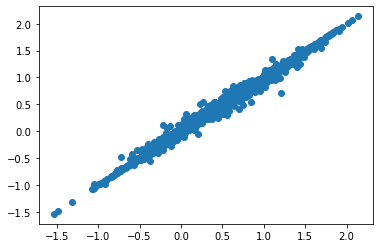

In [106]:
plt.scatter(df_sam['h_cor_med'], df_sam['h_cor_mean'])

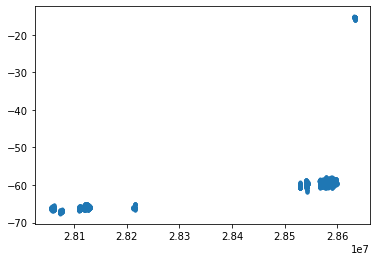

In [102]:
plt.plot(df_sam['x'], df_sam['height_mean'], '.')